Aggregated summary saved to: D:/AIML/reddit mental health/tf_env/data/processed/insights_output\master_aggregated_summary.csv
Global Averages: Positive 15.78%, Negative 84.22%, Neutral 0.00%


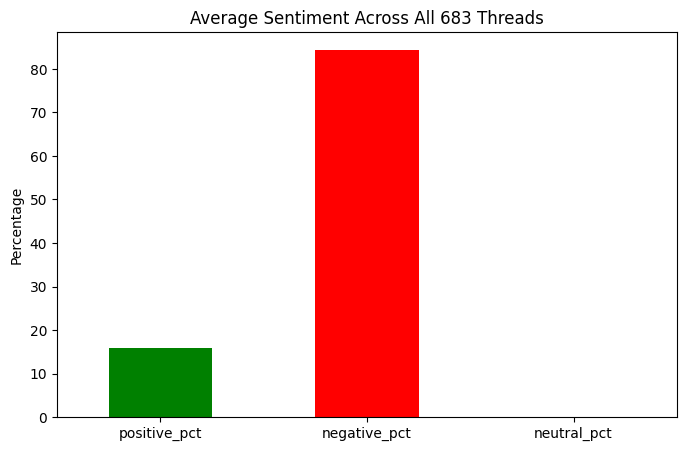

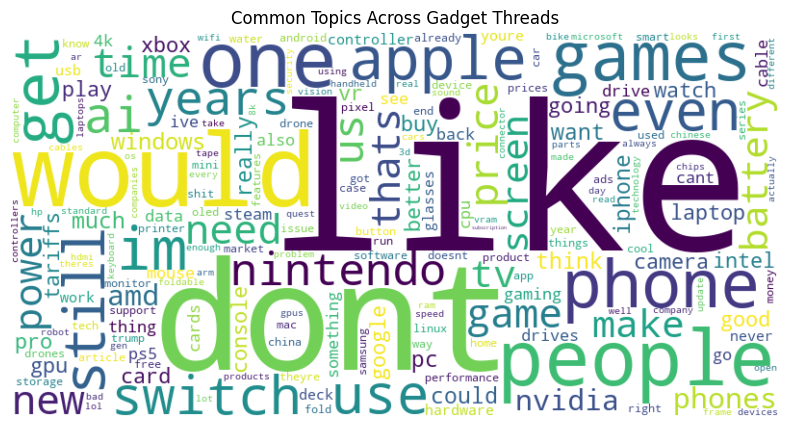

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Paths (update if needed)
output_folder = "D:/AIML/reddit mental health/tf_env/data/processed/insights_output"  # Folder with 683 _insights.csv files
master_summary_path = os.path.join(output_folder, "master_aggregated_summary.csv")

# Step 1: Aggregate all per-thread CSVs
aggregated_data = []
all_topics = []  # For global topic analysis
for filename in os.listdir(output_folder):
    if filename.endswith('_insights.csv'):
        file_path = os.path.join(output_folder, filename)
        df = pd.read_csv(file_path)
        
        # Extract sentiments and topics
        sentiments = df[df['metric'].isin(['Positive %', 'Negative %', 'Neutral %'])]
        topics = df[~df['metric'].isin(['Positive %', 'Negative %', 'Neutral %'])]['metric'].tolist()
        
        aggregated_data.append({
            'thread_id': filename.replace('_insights.csv', ''),
            'positive_pct': sentiments[sentiments['metric'] == 'Positive %']['value'].values[0],
            'negative_pct': sentiments[sentiments['metric'] == 'Negative %']['value'].values[0],
            'neutral_pct': sentiments[sentiments['metric'] == 'Neutral %']['value'].values[0],
            'topics': '; '.join(topics)
        })
        all_topics.extend([word for topic in topics for word in topic.split() if word not in ['Topic', '1:', '2:', '3:']])  # Extract words for global view

# Save aggregated master summary
master_df = pd.DataFrame(aggregated_data)
master_df.to_csv(master_summary_path, index=False)
print(f"Aggregated summary saved to: {master_summary_path}")

# Calculate global averages
avg_positive = master_df['positive_pct'].mean()
avg_negative = master_df['negative_pct'].mean()
avg_neutral = master_df['neutral_pct'].mean()
print(f"Global Averages: Positive {avg_positive:.2f}%, Negative {avg_negative:.2f}%, Neutral {avg_neutral:.2f}%")

# Step 2: Visualize
# Sentiment Distribution Bar Chart
plt.figure(figsize=(8, 5))
master_df[['positive_pct', 'negative_pct', 'neutral_pct']].mean().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Average Sentiment Across All 683 Threads')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.savefig(os.path.join(output_folder, 'sentiment_chart.png'))
plt.show()

# Word Cloud for Common Topics
topic_freq = Counter(all_topics)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Topics Across Gadget Threads')
plt.savefig(os.path.join(output_folder, 'topics_wordcloud.png'))
plt.show()


In [9]:
import pandas as pd
import spacy

# Load NLP tools with automatic model download
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Load your CSV (update path if needed)
df = pd.read_csv('D:/AIML/reddit mental health/tf_env/data/processed/insights_output/master_aggregated_summary.csv')

# Extract products (e.g., "iPhone", "PS5") from topics
def extract_products(topics):
    doc = nlp(topics)
    products = [ent.text for ent in doc.ents if ent.label_ in ['PRODUCT', 'ORG']]
    return '; '.join(set(products)) if products else 'N/A'

df['detected_products'] = df['topics'].apply(extract_products)

# Generate human-readable summary per thread using rule-based approach
def generate_summary(row):
    # Determine sentiment description
    if row['positive_pct'] > 70:
        sentiment_desc = "overwhelmingly positive"
    elif row['positive_pct'] > 55:
        sentiment_desc = "mostly positive"
    elif row['negative_pct'] > 70:
        sentiment_desc = "overwhelmingly negative"
    elif row['negative_pct'] > 55:
        sentiment_desc = "mostly negative"
    else:
        sentiment_desc = "mixed"
    
    # Extract key topic words (first 3 meaningful words)
    topic_words = str(row['topics']).split()[:3]
    topic_summary = ' '.join(topic_words) if topic_words else "general discussion"
    
    # Create summary
    summary = f"Thread {row['thread_id']}: {sentiment_desc} sentiment ({row['positive_pct']:.1f}% positive, {row['negative_pct']:.1f}% negative) discussing {topic_summary}"
    
    return summary

df['readable_summary'] = df.apply(generate_summary, axis=1)

# Save enhanced CSV
enhanced_path = 'D:/AIML/reddit mental health/tf_env/data/processed/enhanced_summary.csv'
df.to_csv(enhanced_path, index=False)
print(f"Enhanced CSV saved to: {enhanced_path}")

# Preview
print(df[['thread_id', 'detected_products', 'readable_summary']].head())


Enhanced CSV saved to: D:/AIML/reddit mental health/tf_env/data/processed/enhanced_summary.csv
  thread_id detected_products  \
0   1ggfmyg               N/A   
1   1ggjfl9              sony   
2   1ggnkgn               N/A   
3   1gh41pn               N/A   
4   1gh6wk4               N/A   

                                    readable_summary  
0  Thread 1ggfmyg: overwhelmingly negative sentim...  
1  Thread 1ggjfl9: overwhelmingly negative sentim...  
2  Thread 1ggnkgn: overwhelmingly negative sentim...  
3  Thread 1gh41pn: overwhelmingly negative sentim...  
4  Thread 1gh6wk4: overwhelmingly negative sentim...  
